This Jupyter Notebook is not an official Emcee Tutorial Notebook, but builds up loosely from the Tutorial of
David Foreman-Mackey concerning Gaussian Processes (https://github.com/dfm/gp/)

In [21]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.linalg as scplin
import scipy.optimize as sopt
from IPython.core.pylabtools import figsize

In [25]:
# Define some kernels
def expsq_kernel(u, v, lam):
    """
    The exponential-squared kernel function.
    :param u: ''(N_u, vec_dim)'' The first kernel array with N_u vectors (with size vec_dim each)
    :param v: ''(N_v, vec_dim)'' The second kernel array with N_v vectors (with size vec_dim each)
    :param lam: ''scalar'' The width-parameter of the kernel
    
    :returns K: The kernel matrix which should be of size (N_u, N_v)
    """
    # Make both u and v 3-dimensional arrays (where the last axis is over the different vectors)
    u = u[:, None, :]
    v = v[None, :, :]
    
    # Calculate the norm of the differences (along axis-2)
    # Remark: axis-2 is the axis along the different vectors of both datasets
    diff_norm = np.linalg.norm(u-v, axis=2)
    
    # Return kernel matrix calculated by taking the gaussian for each element
    return np.exp(-diff_norm**2/0.5/lam**2)

def poly_kernel(u, v, deg):
    """
    The polynomial kernel function.
    :param u: ''(N_u, vec_dim)'' The first kernel array with N_u vectors (with size vec_dim each)
    :param v: ''(N_v, vec_dim)'' The second kernel array with N_v vectors (with size vec_dim each)
    :param deg: ''scalar'' The degree of the polynomial
    
    :returns K: The kernel matrix which should be of size (N_u, N_v)
    """
    # The kernel matrix K is given by '<u,v>^d' which in our case of 2d arrays becomes dot(u, v.T)^d
    return np.dot(u, v.T)**deg

(3, 1)
(3, 3)


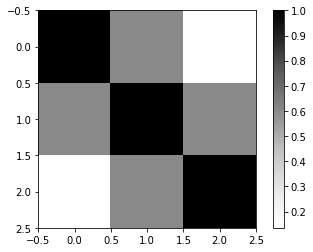

[[1.         0.60653066 0.13533528]
 [0.60653066 1.         0.60653066]
 [0.13533528 0.60653066 1.        ]]
(3, 3)


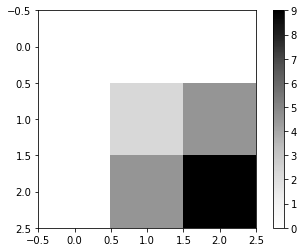

[[0.   0.   0.  ]
 [0.   2.25 4.5 ]
 [0.   4.5  9.  ]]
(3, 3)


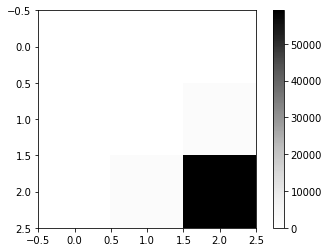

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.76650391e+01 1.84528125e+03]
 [0.00000000e+00 1.84528125e+03 5.90490000e+04]]


In [3]:
# Generate some datapoints
x1 = np.linspace(0, 3, 3).reshape(-1, 1)
x2 = np.linspace(0, 3, 4).reshape(-1, 1)
print(x1.shape)

# Define some
lam = 3

# Get the exponential squared kernel matrix of x itself
cov = expsq_kernel(x1, x1, lam)
print(cov.shape)

# Plot the covariance matrix
plt.imshow(cov, cmap="Greys")
plt.colorbar()
plt.show();
print(cov)

cov = poly_kernel(x1, x1, 1)
print(cov.shape)

# Plot the covariance matrix
plt.imshow(cov, cmap="Greys")
plt.colorbar()
plt.show();
print(cov)

cov = poly_kernel(x1, x1, 5)
print(cov.shape)

# Plot the covariance matrix
plt.imshow(cov, cmap="Greys")
plt.colorbar()
plt.show();
print(cov)

<h1>Gaussian Process Likelihood</h1>
<h2>Marginal Likelihood Derivation</h2>
<div>
    We assume the data $\{(x_j, y_j, \sigma_j)\}_j$ (where here $x_j$ can be vectorial, $y_j$ and $\sigma_j$ are scalar) fullfills the following relation
    \begin{equation}
        y_j = f_{model}(x_j|\vec{\theta})+f_{noise}(x_j|\vec{\lambda})+\epsilon_j
    \end{equation}
    where $f_{model}$ is our model to describe the data, $f_{noise}$ is some (unknown) functional
    term incorporating all the noise and $\epsilon$ are the gaussian errors (which we know exist).
    <br>
    So the likelihood can be modelled as
    \begin{equation}
        p(y_j|x_j, \sigma_j, \vec{\theta}, f_{noise}, \vec{\lambda}) 
        = 
        \frac{\exp^{\big[-\frac{y_j-f_{model}(x_j|\vec{\theta})+f_{noise}(x_j|\vec{\lambda})}{2\sigma_j}\big]}}{\sqrt{2\pi\sigma_j^2}}
    \end{equation}
    which for i.i.d. datapoints turns into a multivariate gaussian distribution with covariance matrix
    $\Sigma=diag(\sigma_1^2, ..., \sigma_N^2)$.
    For convenience reasons we will rewrite this by defining the residues of y-data and the model values
    $r_j(\vec{\theta})=y_j-f_{model}(x_j|\vec{\theta})$.
    <br>
    One can show that using a gaussian process prior of the form $p(f_{noise}) = \mathcal{N}(\vec{0}, K(\vec{\lambda}))$ for the noise
    terms - where the covariance $K$ is given by $K_{ij}(\vec{\lambda})=k(x_i, x_j|\vec{\lambda})$ with some kernel function $k(.,.|\vec{\lambda})$ which depends on some hyperparameters $\vec{\lambda}$ - we get a marginal (over the noise) likelihood of
    \begin{equation}
        p(y_j|x_j, \sigma_j, \vec{\theta}, \vec{\lambda}) 
        = 
        \int p(y_j|x_j, \sigma_j, \vec{\theta}, f_{noise}, \vec{\lambda})p(f_{noise})df_{noise}
        =
        \mathcal{N}(\vec{r}(\vec{\theta}), C(\vec{\lambda}))
    \end{equation}
    with the covariance matrix $C_{ij}(\lambda)=\sigma_j^2\delta_{ij}+K_{ij}(\lambda)$.
    <br>
    The (marginal) log-likelihood is then given by
    \begin{equation}
        ln\big(p(y_j|x_j, \sigma_j, \vec{\theta}, \vec{\lambda})\big) 
        = 
        -\frac{1}{2}\vec{r}^{T}(\vec{\theta})C^{-1}(\vec{\lambda})\vec{r}(\vec{\theta})
        -\frac{1}{2}\ln\big(|C(\vec{\lambda})|\big) 
        - \frac{N\ln(2\pi)}{2}
    \end{equation}    
</div>

<h2>Intermezzo: Cholesky Decomposition</h2>
<div>
  The Cholesky Decomposition, of some hermitian positive definite matrix $A$, can be formulated as
  \begin{equation}
     A = \tilde{L}D\tilde{L}^{\dagger}=LL^{\dagger}
  \end{equation}
  with $\tilde{L}$ a normed lower diagonal matrix and $D$ a diagonal matrix (with positive and real entries). 
  We have defined $L=\tilde{L}D^{1/2}$ to abbreviate this expression ($L$ is also a lower diagonal matrix).
  <br>
  Using this expression a system of equations in the form $Ax=b$ can be solved via
  \begin{align}
     Ly=b\quad\text{solving for y} (y=L/b)\\
     L^{\dagger}x=y\quad\text{solving for x} (x=L^{\dagger}/y)\\
  \end{align}
  so that
  \begin{align}
     x = L^{\dagger}/(L/b)
  \end{align}
  which is fast because $L$ is a lower diagonal matrix.
  In addition, the determinant of the matrix A can be calculated using
  \begin{equation}
     \det(A) = \prod_{i}L_{ii}^2.
  \end{equation}
  <br>
  Remark: In case the matrix A is real, L will also be real and hence $L^{\dagger}=L^{T}$
</div>

<h2>Rewriting the marginal likelihood using the cholesky decomposition</h2>
<div>
    Calculating $A^{-1}b=x$ (for known $A$ and $b$) is equivalent to solving $Ax=b$ for $x$. The former can be faster
    for small matrices, while for bigger matrices there are matrix decomposition tricks which can (possibly) make 
    the latter faster. One of these is solving for x using the Cholesky Decomposition as discussed in the 
    previous paragraph.
    <br>
    In the (marginal) log-likelihood, there is a term $\vec{\alpha}=C^{-1}(\vec{\lambda})\vec{r}(\vec{\theta})$, which can
    be solved using the cholesky decomposition of $C(\vec{\lambda})$ ($L=Choleksy[C]$) and then solving 
    $\vec{\alpha}=L^{T}/[L/\vec{r}(\vec{\theta})]$.
    <br>
    Furthermore, we can use the Cholesky Decomposed Matrix to obtain determinant of $K$ (as shown above), so that
    \begin{equation}
        \frac{1}{2}\ln\big(|C(\vec{\lambda})|\big) 
        =\frac{1}{2}\ln(\prod_{i}L_{ii}^2)
        =\sum_{i} \frac{1}{2}\ln(L_{ii}^2)
        =\sum_{i} \ln(L_{ii}).
    \end{equation}
    <br>
    Using these relations the (marginal) log-likelihood can be written as (up to a constant)
    \begin{equation}
        ln\big(p(y_j|x_j, \sigma_j, \vec{\theta}, \vec{\lambda})\big) 
        = 
        -\frac{1}{2}\vec{r}^{T}(\vec{\theta})\vec{\alpha}
        -\sum_{i} \ln(L_{ii})
    \end{equation}
    where
    \begin{align}
        L &= Cholesky[C(\vec{\lambda})] \\
        \vec{\alpha} &= L^{T}/[L/\vec{r}(\vec{\theta})].
    \end{align}
</div>

In [4]:
# We write down the (marginal) log-likelihood of the gaussian process as a python function
def log_likelihood(r, C):
    """
    The multivariate (marginal) Gaussian Process Log-Likelihood (up to a constant) for the
    residual vector ''r'' and a covariance matrix K.
    
    :param r: ''(N,)'' The residual vector with ''N'' points.
    :param C: ''(N, N)'' The square (''NxN'') covariance matrix.
    
    :returns ln-likelihood: ''float'' The Gaussian Process ln-likelihood
    """
    # Do the Cholesky Decomposition of the matrix C
    # Remark: We would like to have the low-triangular decomposition matrix L but actually it wouldn't matter
    L, low = scplin.cho_factor(C, lower=True)
    
    # Solve for the vector alpha=C^{-1}*r <=> C*alpha=r using the cholesky decomposition of C
    alpha = scplin.cho_solve((L, low), r)
    
    # Calculate the first part of the log-likelihood
    log_likelihood_1 = -0.5*np.dot(r.T, alpha)
    
    # Caclulate the second part of the log-likelihood
    log_likelihood_2 = -np.sum(np.diag(L))
    
    # Return the sum of these two parts
    return log_likelihood_1+log_likelihood_2


In [5]:
# Define the log-posterior for the GP process
def gp_log_posterior(params, model_log_prior_fn, kernel_log_prior_fn, log_like_fn, kernel_fn, model_fn, x, y, yerr):
    
    # 0) Preparations
    # Get the number of model function parameters
    num_model_fn_params = model_fn.num_params
    
    # Use this to extract the model_fn parameters and the kernel_fn parameters from 'parameters'
    model_fn_params  = params[:num_model_fn_params]
    kernel_fn_params = params[num_model_fn_params:]
    
    
    # 1) Compute Priors
    # Compute the model parameters log-prior
    model_log_prior = model_log_prior_fn(model_fn_params)
    
    # Check if the log-prior is not-finite (if it is not, return -infty)
    if not np.isfinite(model_log_prior):
        return -np.inf
    
    # Compute the kernel parameters log-prior
    kernel_log_prior = kernel_log_prior_fn(kernel_fn_params)
    
    # Check if the log-prior is not-finite (if it is not, return -infty)
    if not np.isfinite(kernel_log_prior):
        return -np.inf
    
    
    # 2a) Model Evaluation
    # Set the parameters of the model_fn
    model_fn.set_parameter_vector(model_fn_params)
    
    # Compute the residual vector
    r = y - model_fn.get_value(x)
    
    # 2b) Kernel Evaluation
    # Compute the kernel covariance matrix using the kernel_fn (and on the data x)
    K = kernel_fn(x, x, kernel_fn_params)
    
    # The whole covariance matrix C is given by the kernel covariance matrix K 
    # plus the diagonal matrix containing the data errors squared
    C = K+np.diag(yerr**2)
    
    
    # 3) Compute the log-likelihood
    log_like = log_like_fn(r, C) 
    
    return log_like + model_log_prior + kernel_log_prior

In [6]:
# Define some model
class LinearModel:
    def __init__(self, p=None):
        # Initialize the parameter vector ([m, b])
        if p is None:
            self._p = np.array([1, 0]).reshape(-1, 2)
        else:
            if isinstance(p, list):
                self._p = np.array(p).reshape(-1, 2)
            else:
                if p.ndim==1:
                    self._p = p.reshape(-1, 2)
                else:
                    self._p = p
        
    def get_value(self, x):
        # Make x a 2d array
        x = x.reshape(1, -1)
        
        # Return the linear model x*p_0+p_1
        return np.dot(self._p[:, 0], x)+self._p[:, 1]
    
    def set_parameter_vector(self, p):
        if p.ndim==1:
            self._p = p.reshape(-1, 2)
        else:
            self._p = p
        
    @property
    def num_params(self):
        return 2
    
class ZeroModel:
    def __init__(self):
        # Initialize a p
        self._p = None
        
    def get_value(self, x):
        # Return a 1d zeros array with #number_samples (axis-0 in x) many elements
        return np.zeros(x.shape[0])
    
    def set_parameter_vector(self, p):
        self._p = p
        
    @property
    def num_params(self):
        return 0  

[]


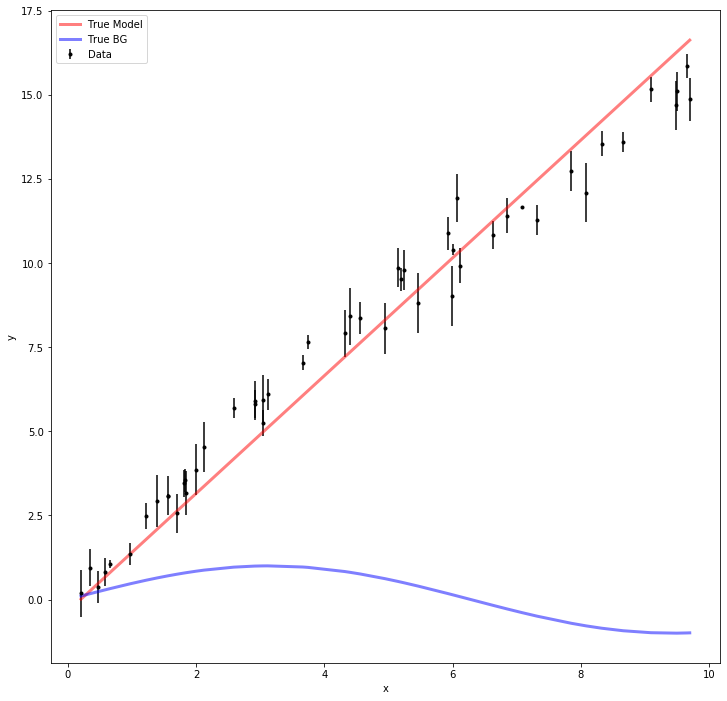

In [202]:
# Define quantities
m_true = 1.75
b_true = -0.35

np.random.seed(42)
N = 50

# Define some bg parameters
#bg_p_0_true = 0
#bg_p_1_true = 0
#bg_p_2_true = 0.25
bg_periodic = [1, 0, 0.5]

def bg_periodic_func(x, params):
    return params[0]*np.sin((x-params[1])*params[2]).squeeze()

# Linear Model
model_fn = LinearModel(p=[m_true, b_true])
#model_fn.set_parameter_vector(np.array([m_true, b_true]))

#model_fn = ZeroModel()
test = [1,2,3]
print(test[:0])
#model_fn.set_parameter_vector(test[:0])

# Generate some data
x_data = np.sort(np.random.rand(N)*10).reshape(-1, 1)
y_data_model = model_fn.get_value(x_data)
yerr_data = np.abs(0.5+0.25*np.random.randn(N))
#y_data_bg = (bg_p_0_true+bg_p_1_true*x_data+bg_p_2_true*x_data**2).squeeze()
y_data_bg = bg_periodic_func(x_data, bg_periodic)
y_data = y_data_model + y_data_bg + yerr_data*np.random.randn(N)

figsize(12, 12)
plt.errorbar(x_data, y_data, yerr=yerr_data, fmt=".k", capsize=0, label="Data")
plt.plot(x_data, y_data_model, c='r', lw=3, alpha=0.5, label="True Model")
plt.plot(x_data, y_data_bg, c='b', lw=3, alpha=0.5, label="True BG")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

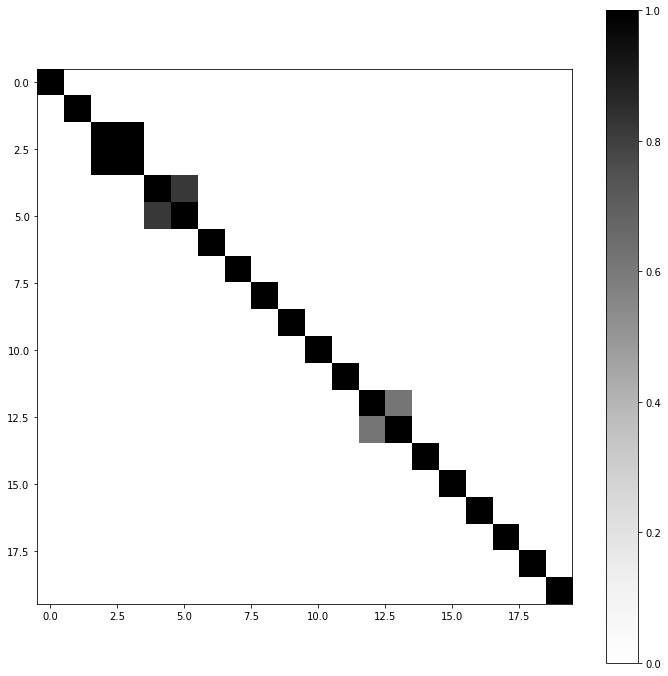

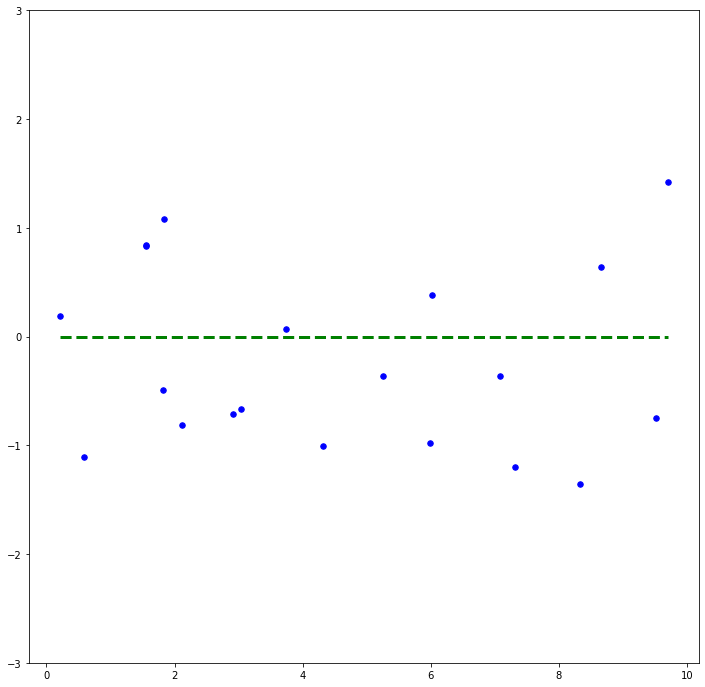

In [144]:
# Define some kernel function
kernel_fn = lambda u, v, params: params[0]*expsq_kernel(u, v, params[1])

# Calculate the kernel covariance matrix
cov_mat = kernel_fn(x_data, x_data, [1, 0.05])
plt.imshow(cov_mat, cmap="Greys")
plt.colorbar()
plt.show()

# Sample a gaussian process
y_gp_sampled = stats.multivariate_normal.rvs(cov=cov_mat, size=1)

plt.scatter(x_data, y_gp_sampled, s=30, color='b')
plt.hlines(0, np.min(x_data), np.max(x_data), linewidths=3, linestyles='--', color='g')
plt.ylim(-3, 3)
plt.show()

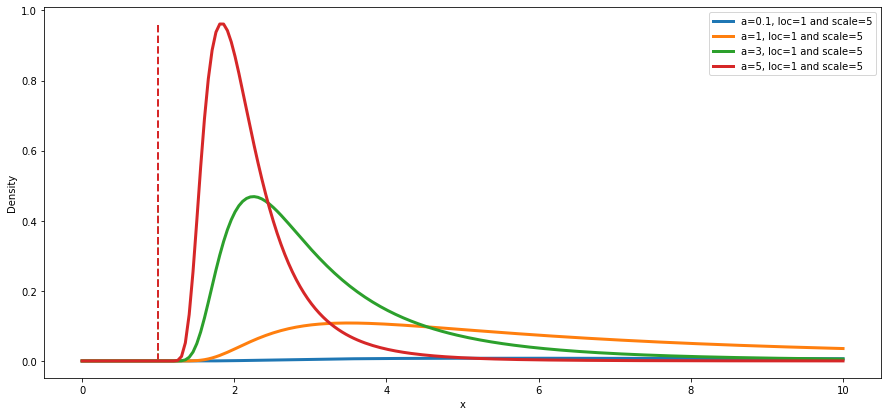

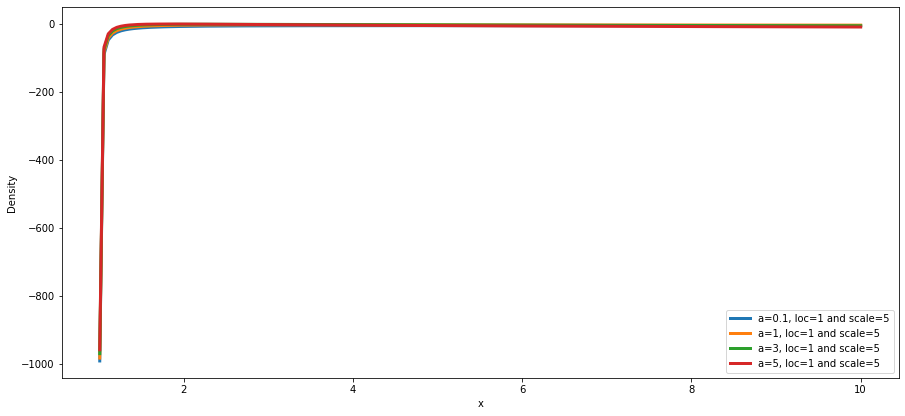

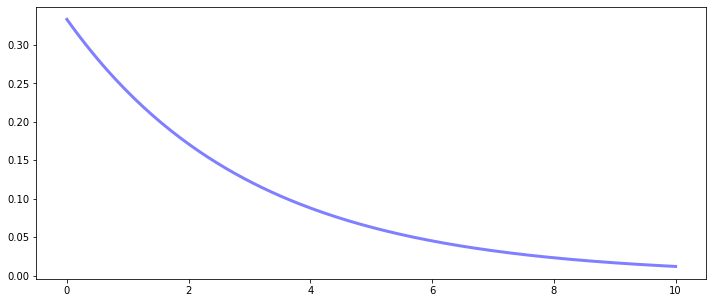

In [171]:
# Plot some inverse gamma distr
figsize(15, 15)
t = np.linspace(0, 10, 200)
params = [(0.1, 1, 5), (1, 1, 5), (3, 1, 5), (5, 1, 5)]


plt.subplot(211)
for ind, param in enumerate(params):
    a, loc, scale = param
    pdf_t = stats.invgamma.pdf(t, a, loc=loc, scale=scale)
    plt.plot(t, pdf_t, color="C"+str(ind), lw=3, 
             label=r"a={:}, loc={:} and scale={:}".format(a, loc, scale))
    plt.vlines(loc, 0, np.max(pdf_t), linestyles='--', color="C"+str(ind), linewidth=2)
    
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show();

plt.subplot(212)
# Plot the logarithm
for ind, param in enumerate(params):
    a, loc, scale = param
    pdf_t = stats.invgamma.logpdf(t, a, loc=loc, scale=scale)
    plt.plot(t, pdf_t, color="C"+str(ind), lw=3, 
             label=r"a={:}, loc={:} and scale={:}".format(a, loc, scale))
    plt.vlines(loc, np.min(pdf_t), np.max(pdf_t), linestyles='--', color="C"+str(ind), linewidth=2)
    plt.plot()
    
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show();

figsize(12, 5)
plt.plot(t, stats.expon.pdf(t, loc=0, scale=3), lw=3, c="b", alpha=0.5);

In [172]:
# Define some priors
def model_log_prior(params):
    """Define a log prior for the model parameters."""
    # Access the params
    m, b = params
    
    # Use a gaussian prior for b, centered at 0 and with a certain scale
    norm_scale = 1
    log_prior_b = stats.norm.logpdf(x=b, loc=0, scale=norm_scale)
    
    # Use an exponential prior for m with a certain scale
    expon_scale = 1
    log_prior_m = stats.expon.logpdf(x=m, loc=0, scale=expon_scale)
    
    return log_prior_b + log_prior_m
    
def kernel_log_prior(params):
    """Define a log prior for the kernel parameters."""
    # Access the kernel params
    sigma_2, lam = params
    
    # Use an exponential prior for sigma_2 with a certain scale
    expon_scale = 2
    log_prior_sigma_2 = stats.expon.logpdf(x=sigma_2, loc=0, scale=expon_scale)
    
    # Use an inverse gamma prior for lam with certain parameters
    ig_a, ig_loc, ig_scale = 3, 1, 3
    log_prior_lam = stats.invgamma.logpdf(x=lam, a=ig_a, loc=ig_loc, scale=ig_scale)
    
    return log_prior_sigma_2 + log_prior_lam

In [203]:
# Search for MAP using the negative log posterior (and scipy minsearch)
ngplp = lambda *args: -gp_log_posterior(*args)

# Define some initial parameters
# (m, b, sigma_2, lam)
params_init_minimization = np.array([1, 0, 2, 2])
# (sigma_2, lam)
#params_init_minimization = np.array([2, 2])

val = ngplp(params_init_minimization, model_log_prior, kernel_log_prior, log_likelihood, kernel_fn, model_fn, x_data, y_data, yerr_data)
print("Initial Value -log_posterior:", val)

# Minimize the ngplp
np.random.seed(123)
args_gp_log_post=(model_log_prior, kernel_log_prior, log_likelihood, kernel_fn, model_fn, x_data, y_data, yerr_data)
soln = sopt.minimize(ngplp, params_init_minimization, args=args_gp_log_post)

# Get the Maximum a posterior parameters
params_MAP = soln.x

print("params MAP:", params_MAP)

Initial Value -log_posterior: 77.50396701054622
params MAP: [1.58202408 0.56907314 0.32145214 2.07483844]


<h1>Predicting new values</h1>
<div>
    For a new point $\vec{x}_\ast$, we can predict a residual value (actually mean and variance of it) 
    $r_\ast=r(\vec{x}_\ast)=y_\ast-f_{model}(\vec{x}_\ast)$ via
    \begin{align}
        \mu(r_\ast) &= \vec{k}_\ast^TC^{-1}(\vec{\lambda})\vec{r}\\
        \sigma^2(r_\ast) &= k(x_\ast, x_\ast)-\vec{k}_\ast^TC^{-1}(\vec{\lambda})\vec{k}_\ast
    \end{align}
    where $C_{ij}(\vec{\lambda})=k(\vec{x}_i, \vec{x}_j)+\sigma^2_j\delta_{ij}$ (C is a NxN-matrix) and
    \begin{equation}
        \vec{k}_\ast^T = [k(\vec{x}_1, \vec{x}_\ast), ..., k(\vec{x}_N, \vec{x}_\ast)]
    \end{equation}
    is a N-vector.
    <br>
    We can also write this for a set of new points $\vec{X}_\ast=\{\vec{x}_\ast^1, ..., \vec{x}_\ast^M\}$
    to predict the vectorized residual values (actually means and variances of these) $\vec{r}_\ast$ as
    \begin{align}
        \vec{\mu}(\vec{r}_\ast) &= K_\ast^TC^{-1}(\vec{\lambda})\vec{r}\\
        \Sigma(\vec{r}_\ast) &= K_{\ast\ast}-K_\ast^TC^{-1}(\vec{\lambda})K_\ast
    \end{align}
    where now [$k(x_\ast, x_\ast)\rightarrow K_{\ast\ast}$]
    \begin{equation}
        K_{\ast\ast}^{ij} = k(\vec{x}_\ast^i, \vec{x}_\ast^j)
    \end{equation}
    is MxM matrix and [$\vec{k}_\ast\rightarrow K_\ast$]
    \begin{equation}
        K_\ast^T = 
        \begin{pmatrix}
            k(\vec{x}_1, \vec{x}_\ast^1) & \dots & k(\vec{x}_N, \vec{x}_\ast^1)\\
            k(\vec{x}_1, \vec{x}_\ast^2) & \dots & k(\vec{x}_N, \vec{x}_\ast^2)\\
            \vdots   & \vdots & \vdots \\
            k(\vec{x}_1, \vec{x}_\ast^M) & \dots & k(\vec{x}_N, \vec{x}_\ast^M)
        \end{pmatrix}
    \end{equation}
    is a MxN matrix.
    <br>
    For the univariate case it might make sense to apply a Cholesky decomposition for $C(\vec{\lambda})$,
    as for the (marginal) GP posterior, instead of inverting $C(\vec{\lambda})$. 
    In the multivariate case
</div>

In [146]:
def kernel_predict(kernel_fn, kernel_params, x, r, yerr, x_pred, mean_only=True):
    # Compute the kernel covariance matrix using the kernel_fn (and on the data x)
    K = kernel_fn(x, x, kernel_params)
    
    # The whole covariance matrix C is given by the kernel covariance matrix K 
    # plus the diagonal matrix containing the data errors squared
    C = K+np.diag(yerr**2)
    
    # Calculate K*
    K_star = kernel_fn(x, x_pred, kernel_params)
    
    # Calculate K**
    K_starstar = kernel_fn(x_pred, x_pred, kernel_params)
    
    # Differ cases
    if mean_only:
        # Do the Cholesky Decomposition of the matrix C
        # Remark: We would like to have the low-triangular decomposition matrix L but actually it wouldn't matter
        L, low = scplin.cho_factor(C, lower=True)

        # Solve for the vector alpha=C^{-1}*r <=> C*alpha=r using the cholesky decomposition of C
        alpha = scplin.cho_solve((L, low), r)

        # Calculate the mean vector
        mean_pred = np.dot(K_star.T, alpha)
        
        # Set the var_pred to a matrix filled with nans
        var_pred = np.full((mean_pred.shape[0], mean_pred.shape[0]), np.nan)
        
        return mean_pred, var_pred
    else:
        # Invert C
        C_inv = scplin.inv(C)
        
        # Calculate the mean vector
        mean_pred = np.dot(K_star.T, np.dot(C_inv, r))
        
        # Calculate the variance matrix
        var_pred  = K_starstar - np.dot(K_star.T, np.dot(C_inv, K_star))
    
        return mean_pred, var_pred

In [182]:
def predict_y(params, model_fn, kernel_fn, x, y, yerr, x_pred):
    # Get the number of model parameters
    num_model_params = model_fn.num_params
    
    # Get the model and kernel parameters
    model_params  = params[:num_model_params]
    kernel_params = params[num_model_params:]
    
    # Set the model parameters
    model_fn.set_parameter_vector(model_params)
    
    # Calculate the model prediction on the data x
    y_model = model_fn.get_value(x)
    
    # Calculate the model prediction on the prediction x
    y_model_pred = model_fn.get_value(x_pred)
    
    # Calculate the residue between y data and y model
    r = y - y_model
    
    # Calculate the kernel predictions
    kernel_mean_pred, kernel_var_pred = kernel_predict(kernel_fn, kernel_params, x_data, r, yerr_data, x_pred)
    kernel_mean_pred_2, kernel_var_pred_2 = kernel_predict(kernel_fn, kernel_params, x_data, r, yerr_data, x_pred, mean_only=False)
    if not np.allclose(kernel_mean_pred, kernel_mean_pred_2):
        print("Using Cholesky and Inversion does not lead to the same mean vector (in predict_y)")
    #print(kernel_var_pred.shape==kernel_var_pred_2.shape)
    
    # Create an output dictionary
    predict_dict = {'y_model': y_model_pred, 'y_kernel': kernel_mean_pred, 'y_full': y_model_pred + kernel_mean_pred}
    
    return predict_dict
    

[0.32145214 2.07483844]
True
True


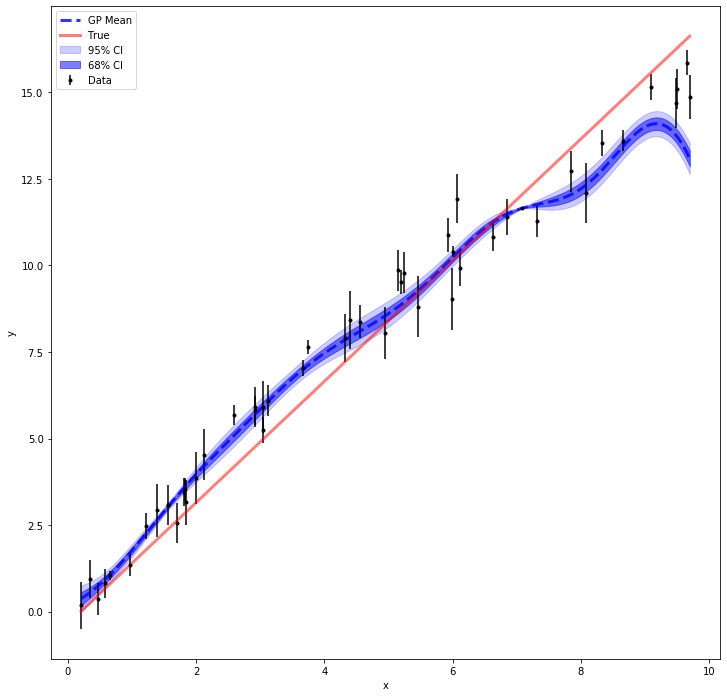

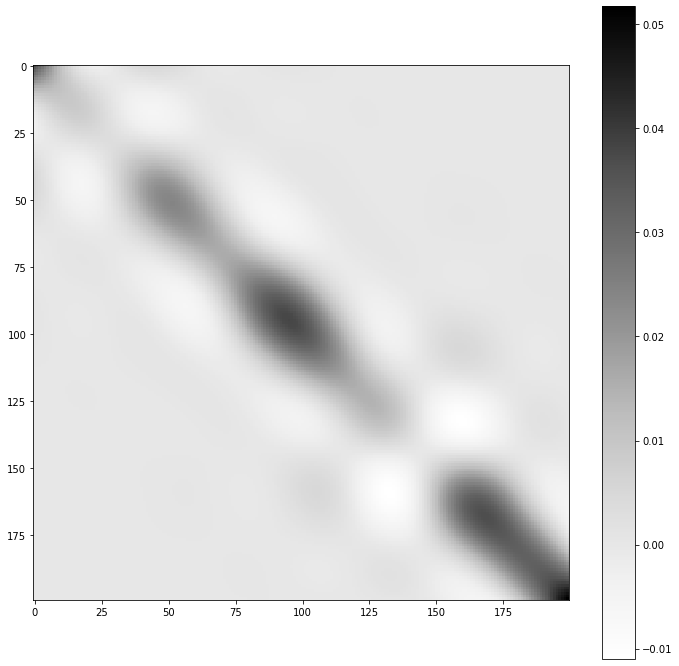

In [204]:
x_pred = np.linspace(np.min(x_data), np.max(x_data), 200).reshape(-1, 1)
num_model_params = model_fn.num_params
kernel_params = params_MAP[num_model_params:]
print(kernel_params)
m, v = kernel_predict(kernel_fn, kernel_params, x_data, y_data, yerr_data, x_pred)
mm, vv = kernel_predict(kernel_fn, kernel_params, x_data, y_data, yerr_data, x_pred, mean_only=False)
print(np.allclose(m, mm))
print(v.shape==vv.shape)

# Get the square root of the diagonal of vv
sigma = np.sqrt(np.diag(vv))

# Plot results
figsize(12, 12)
plt.fill_between(x_pred.squeeze(), m-2*sigma, m+2*sigma, label="95% CI", alpha=0.2, color="b")
plt.fill_between(x_pred.squeeze(), m-sigma, m+sigma, label="68% CI", alpha=0.5, color="b")
plt.plot(x_pred, m, ls='--', lw=3, alpha=0.8, c="b", label="GP Mean")
plt.errorbar(x_data, y_data, yerr=yerr_data, fmt=".k", capsize=0, label="Data")
plt.plot(x_data, y_data_model, c='r', lw=3, alpha=0.5, label="True")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

plt.imshow(vv, cmap="Greys")
plt.colorbar()
plt.show()

0.9701949301966613
-0.5929238389063963


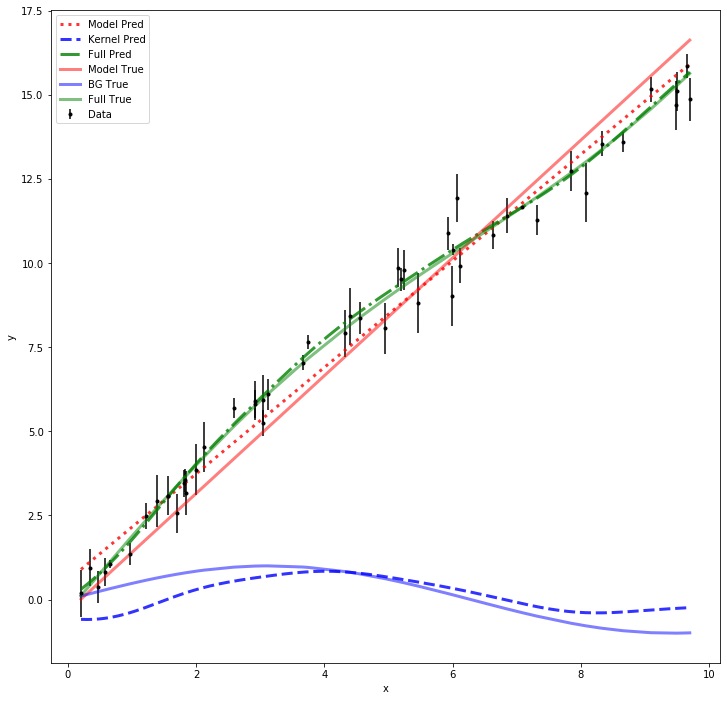

In [206]:
# Predict values
x_pred = np.linspace(np.min(x_data), np.max(x_data), 200).reshape(-1, 1)
predict_dict = predict_y(params_MAP, model_fn, kernel_fn, x_data, y_data, yerr_data, x_pred)
print(predict_dict['y_model'][1])
print(predict_dict['y_kernel'][1])

# Plot results
figsize(12, 12)
#plt.fill_between(x_pred.squeeze(), m-2*sigma, m+2*sigma, label="95% CI", alpha=0.2, color="b")
#plt.fill_between(x_pred.squeeze(), m-sigma, m+sigma, label="68% CI", alpha=0.5, color="b")
plt.plot(x_pred, predict_dict["y_model"], ls=':', lw=3, alpha=0.8, c="r", label="Model Pred")
plt.plot(x_pred, predict_dict["y_kernel"], ls='--', lw=3, alpha=0.8, c="b", label="Kernel Pred")
plt.plot(x_pred, predict_dict["y_full"], ls='-.', lw=3, alpha=0.8, c="g", label="Full Pred")

plt.errorbar(x_data, y_data, yerr=yerr_data, fmt=".k", capsize=0, label="Data")
plt.plot(x_data, y_data_model, c='r', lw=3, alpha=0.5, label="Model True")
plt.plot(x_data, y_data_bg, c='b', lw=3, alpha=0.5, label="BG True")
plt.plot(x_data, y_data_model+y_data_bg, c='g', lw=3, alpha=0.5, label="Full True")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [207]:
# Now do the cool MCMC stuff

# Define the number of walkers
nwalkers = 32

# Define the number of parameters
ndim = 4

# Initialize the walker positions (in the to be sampled parameter space) in 
# a Gaussian ball around the MAP parameters
pos_init = params_MAP + 1e-4 * np.random.randn(nwalkers, ndim)

# Arguments (parameters which should be constant for the solver):
# Defined for MAP determination above as:
#args_gp_log_post=(model_log_prior, kernel_log_prior, log_likelihood, kernel_fn, model_fn, x_data, y_data, yerr_data)

# Define the ensemlbe sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, gp_log_posterior, args=args_gp_log_post)

# Sample for some steps
sampler.run_mcmc(pos_init, 5000, progress=True);

100%|██████████| 5000/5000 [03:00<00:00, 27.68it/s]


[53.44556889 52.05213472 74.31242379 56.98170231]


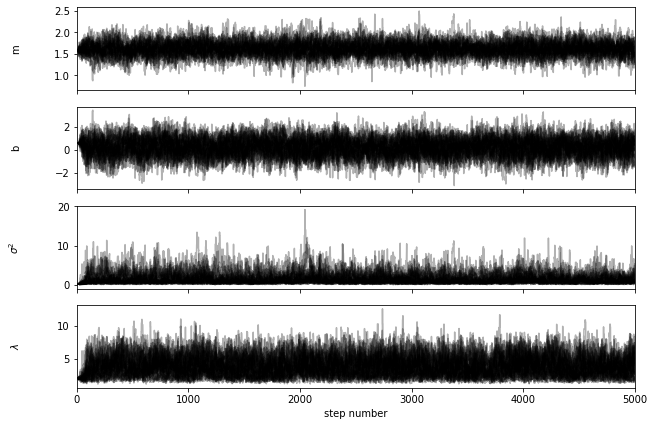

In [208]:
# Lets look at the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", r"$\sigma^2$", r"$\lambda$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

# Print the autocorrelation times for both parameters
tau = sampler.get_autocorr_time()
print(tau)

(6144, 4)


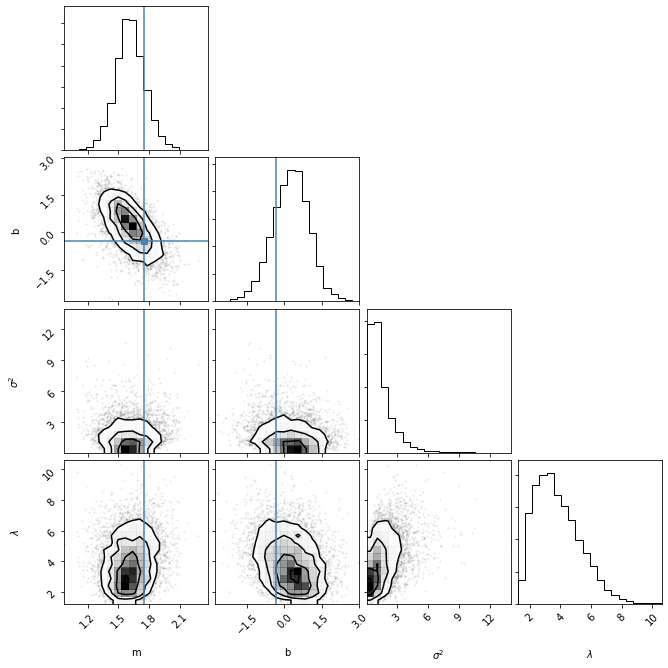

In [209]:
# For each chain discard the first 200, thin them with a step of 30 (around half the autocor time)
# and then combine the chains (flatten them)
flat_samples = sampler.get_chain(discard=200, thin=25, flat=True)
print(flat_samples.shape)

# Make a corner plot
fig = corner.corner(flat_samples, labels=labels, truths=[m_true, b_true, None, None]);

In [139]:
def get_y_posterior(flattened_trace, model_fn, kernel_fn, x_data, y_data, yerr_data, x_pred):
    # Initialize the posterior dictionary using np.nan matrices as entries
    y_posterior_dict = {
                        'model': np.full( (len(flattened_trace), x_pred.shape[0]), np.nan ), 
                        'kernel': np.full( (len(flattened_trace), x_pred.shape[0]), np.nan ), 
                        'full': np.full( (len(flattened_trace), x_pred.shape[0]), np.nan )
                       }

    # Loop over the parameters in the trace
    for index, params in enumerate(flattened_trace):
        # Get the prediction (model, kernel and sum='full')
        predict_dict = predict_y(params, model_fn, kernel_fn, x_data, y_data, yerr_data, x_pred)

        # Assign the mean prediction to y_pred_posterior
        y_posterior_dict['model'][index, :]  = predict_dict['y_model']
        y_posterior_dict['kernel'][index, :] = predict_dict['y_kernel']
        y_posterior_dict['full'][index, :]   = predict_dict['y_full']
                        
    return y_posterior_dict

In [211]:
# Get the posterior of y (model, kernel, full) for some datapoints
x_pred = np.linspace(np.min(x_data), np.max(x_data), 100).reshape(-1, 1)
y_posterior_dict = get_y_posterior(flat_samples, model_fn, kernel_fn, x_data, y_data, yerr_data, x_pred)
print("done")

done


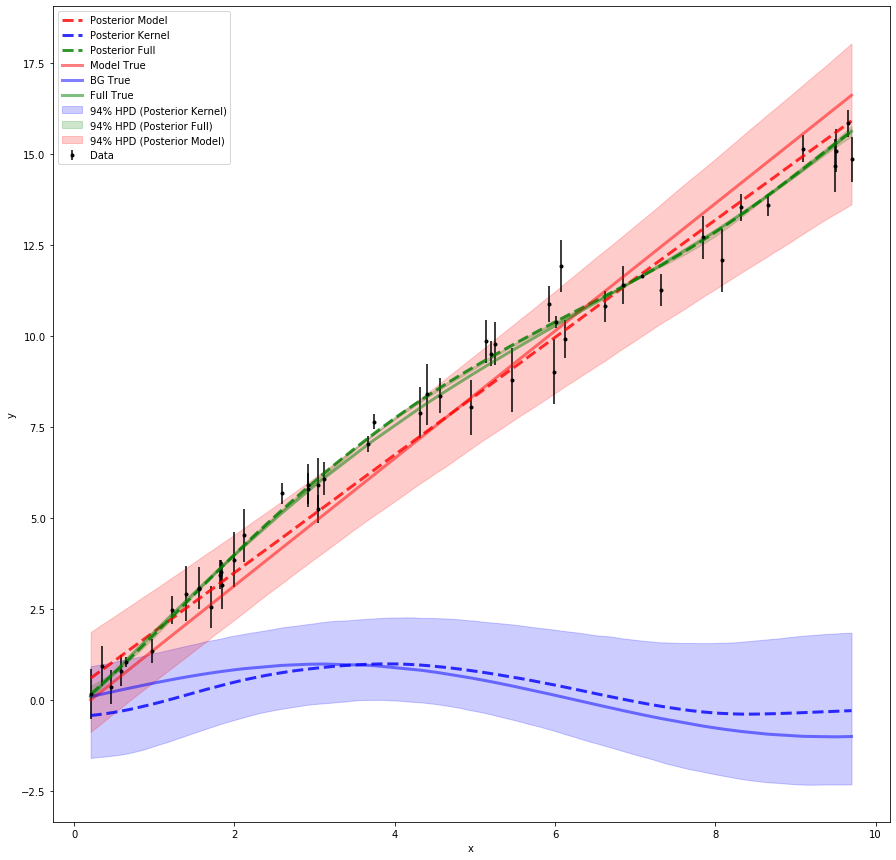

In [212]:
# Get some percentiles for the data (axis-0 is along the trace samples)
percentiles = [3, 50, 97]
y_post_model_sumstat = np.percentile(y_posterior_dict['model'], percentiles, axis=0)
y_post_kernel_sumstat = np.percentile(y_posterior_dict['kernel'], percentiles, axis=0)
y_post_full_sumstat = np.percentile(y_posterior_dict['full'], percentiles, axis=0)


# Plot the results
figsize(15, 15)
plt.fill_between(x_pred.squeeze(), y_post_kernel_sumstat[0], y_post_kernel_sumstat[2], 
                 alpha=0.2, color="b", label="94% HPD (Posterior Kernel)")
plt.fill_between(x_pred.squeeze(), y_post_full_sumstat[0], y_post_full_sumstat[2], 
                 alpha=0.2, color="g", label="94% HPD (Posterior Full)")
plt.fill_between(x_pred.squeeze(), y_post_model_sumstat[0], y_post_model_sumstat[2], 
                 alpha=0.2, color="r", label="94% HPD (Posterior Model)")

plt.plot(x_pred, y_post_model_sumstat[1], ls='--', lw=3, alpha=0.8, c="r", label="Posterior Model")
plt.plot(x_pred, y_post_kernel_sumstat[1], ls='--', lw=3, alpha=0.8, c="b", label="Posterior Kernel")
plt.plot(x_pred, y_post_full_sumstat[1], ls='--', lw=3, alpha=0.8, c="g", label="Posterior Full")

plt.errorbar(x_data, y_data, yerr=yerr_data, fmt=".k", capsize=0, label="Data")
plt.plot(x_data, y_data_model, c='r', lw=3, alpha=0.5, label="Model True")
plt.plot(x_data, y_data_bg, c='b', lw=3, alpha=0.5, label="BG True")
plt.plot(x_data, y_data_model+y_data_bg, c='g', lw=3, alpha=0.5, label="Full True")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show();

In [87]:
# Define exponential squared kernel with vectorized lamda input
def expsq_kernel_vectorized(u, v, lam):
    """
    The exponential-squared kernel function.
    :param u: ''(N_u, vec_dim)'' The first kernel array with N_u vectors (with size vec_dim each)
    :param v: ''(N_v, vec_dim)'' The second kernel array with N_v vectors (with size vec_dim each)
    :param lam: ''(N_lam,)'' The width-parameters of the kernel
    
    :returns K: The kernel matrix which should be of size (N_u, N_v)
    """
    # Make both u and v 4-dimensional arrays (where the last axis is over the different vectors)
    u = u[:, None, :, None]
    v = v[None, :, :, None]
    
    # Make lam also a 4-dimensional array
    lam = lam.reshape(1, 1, 1, -1)
    
    # Calculate the norm of the differences (along axis-2)
    # Remark: axis-2 is the axis along the different vectors of both datasets
    diff_norm = np.linalg.norm(u-v, axis=2)
    
    # Return kernel matrix calculated by taking the gaussian for each element
    return np.exp(-diff_norm**2/0.5/lam**2).squeeze()


In [38]:
kernel_vectorized   = expsq_kernel_vectorized(x_data, x_data, np.array([0.2, 1]))
kernel_unvectorized = expsq_kernel(x_data, x_data, 0.1)
print(kernel_vectorized.shape)
print(kernel_unvectorized.shape)

(20, 20, 2)
(20, 20)


In [191]:
# # OLD:
# # Loop over the trace-samples an calculate the 
# x_pred = np.linspace(np.min(x_data), np.max(x_data), 100).reshape(-1, 1)

# # Generate the a nan matrix which will be filled later
# y_pred_posterior = np.full( (len(flat_samples), x_pred.shape[0]), np.nan )

# for index, flat_sample in enumerate(flat_samples):
#     # Get the parameter values of the current sample
#     mean_pred, var_pred = kernel_predict(kernel_fn, flat_sample, x_data, y_data, yerr_data, x_pred)

#     # Assign the mean prediction to y_pred_posterior
#     y_pred_posterior[index, :] = mean_pred
    

# print(y_pred_posterior.shape)

(6080, 100)


ValueError: operands could not be broadcast together with shapes (100,) (200,) 

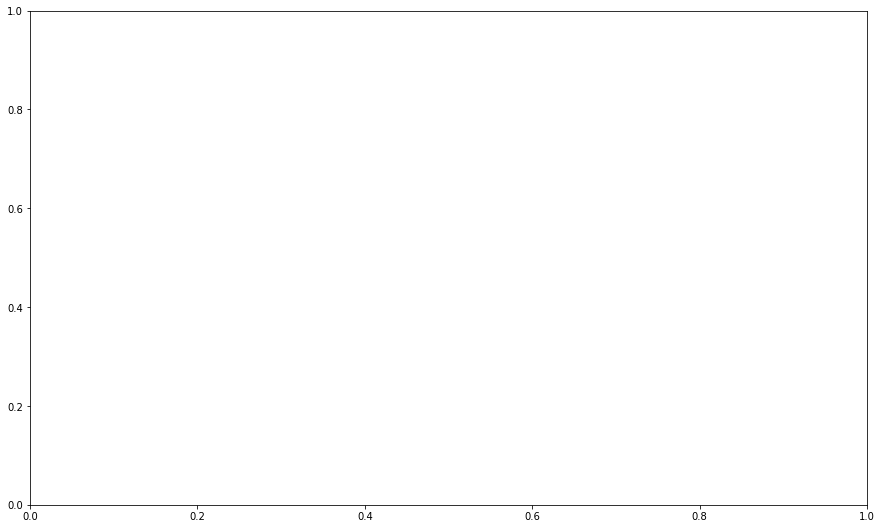

In [192]:
# # OLD:
# # Get the 94% HPD of the posterior for all x (so we calculate it over the samples which is axis=0)
# y_pred_posterior_sumstats = np.percentile(y_pred_posterior, [3, 50, 97], axis=0)

# # Plot results
# figsize(15, 20)
# plt.subplot(211)
# plt.fill_between(x_pred.squeeze(), m-2*sigma, m+2*sigma, label="95% CI (MAP)", alpha=0.2, color="b")
# plt.fill_between(x_pred.squeeze(), m-sigma, m+sigma, label="68% CI (MAP)", alpha=0.5, color="b")
# plt.plot(x_pred, m, ls='--', lw=3, alpha=0.8, c="b", label="GP Mean (MAP)")
# plt.errorbar(x_data, y_data, yerr=yerr_data, fmt=".k", capsize=0, label="Data")
# plt.plot(x_data, y_data_model, c='r', lw=3, alpha=0.5, label="True")
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()

# plt.subplot(212)
# plt.fill_between(x_pred.squeeze(), y_pred_posterior_sumstats[0], y_pred_posterior_sumstats[2], 
#                  alpha=0.2, color="r", label="94% HPD")
# plt.plot(x_pred, y_pred_posterior_sumstats[1], ls=':', lw=5, alpha=0.6, c="r", label="GP Posterior Mean")
# #plt.plot(x_pred, m, ls='--', lw=3, alpha=0.8, c="b", label="GP Mean (MAP)")
# plt.plot(x_pred.squeeze(), bg_periodic_func(x_pred.squeeze(), bg_periodic), c="orange", 
#          lw=3, alpha=0.5, label="True BG")
# plt.errorbar(x_data, y_data, yerr=yerr_data, fmt=".k", capsize=0, label="Data")
# plt.plot(x_data, y_data_model, c='r', lw=3, alpha=0.5, label="True")
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend()
# plt.show();